In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import numpy as np
import torchvision
from BNN import *
from spikingjelly.activation_based import functional

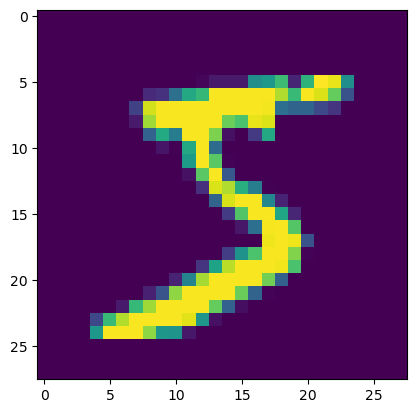

tensor([43487784], dtype=torch.int32)
tensor([[[    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,  -629,  -374,  -127],
         [    0,     0,     0,  ..., -1130,  -633,  -191],
         ...,
         [ -191,  -616, -1113,  ...,     0,     0,     0],
         [ -191,  -616, -1113,  ...,     0,     0,     0],
         [ -191,  -616, -1095,  ...,     0,     0,     0]],

        [[    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,  -629,  -374,  -127],
         [    0,     0,     0,  ..., -1130,  -633,  -191],
         ...,
         [ -191,  -616, -1113,  ...,     0,     0,     0],
         [ -191,  -616, -1113,  ...,     0,     0,     0],
         [ -191,  -616, -1095,  ...,     0,     0,     0]],

        [[    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,  -629,  -374,  -127],
         [    0,     0,     0,  ..., -1130,  -633,  -191],
         ...,
         [ -191,  -616, -1113, 

In [7]:
#加载MNIST数据集
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='/home/curry/code', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='/home/curry/code', train=False, transform=transform, download=True)

#加载MNIST数据集的第一张图片
image, label = train_dataset[0]
#将图片用matplotlib画出来
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().numpy())
plt.show()
#讲image转化为int8类型
image = image * 255
#print(image.int())

#用一个权重全为1的卷积核对图片进行卷积
conv1 = nn.Conv2d(1, 6, 5, 1, 0, bias=False)
conv2 = nn.Conv2d(6, 12, 5, 1, 0, bias=False)
conv1.weight.data.fill_(-1)
conv2.weight.data.fill_(-1)
output = conv1(image)
# print(output.shape)
# print(output.int())
pool = nn.MaxPool2d(2, 2)
fc = nn.Linear(192, 1,bias=False)
fc.weight.data.fill_(1)
output2 = pool(output)
output3 = conv2(output2)
output4 = pool(output3)
output5 = output4.view(-1)
output6 = fc(output5)
print(output6.int())


# print(output2.shape)
# print(output2.int())
#将image转化为32位有符号
image = image.int()

#按行将image转化为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_image_txt.txt', 'w') as f:
    for i in range(28):
        for j in range(28):
            f.write(format(image[0, i, j].item(), '032b') + '\n')
output_int = output.int()
print(output_int)
#按行将output转化为32位有符号整数的txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output_txt.txt', 'w') as f:
    for i in range(24):
        for j in range(24):
            value = output_int[0, i, j].item()
            if value < 0:
                value = (1 << 32) + value  # 将负数转换为32位有符号整数的二进制表示
            f.write(format(value, '032b') + '\n')
output5_int = output5.int()
#将output5转化为32位有符号整数的txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output5_txt.txt', 'w') as f:
    for i in range(192):
        value = output5_int[i].item()
        if value < 0:
            value = (1 << 32) + value
        f.write(format(value, '032b') + '\n')

In [8]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, T=4):
        super().__init__()
        self.T = T
        self.conv1 = BinaryConv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = BinaryConv2d(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = BinaryLinear(12*4*4, 10, bias=False)
        # self.relu3 = nn.ReLU()
        # self.fc2 = BinaryLinear(120, 84, bias=False)
        # self.relu4 = nn.ReLU()
        # self.fc3 = BinaryLinear(84, num_classes, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        # x = self.relu3(x)
        # x = self.fc2(x)
        # x = self.relu3(x)
        # x = self.fc3(x)
        return x

In [9]:
net = LeNet()
functional.set_step_mode(net, 'm')
print(net)

LeNet(
  (conv1): BinaryConv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): BinaryConv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): BinaryLinear(in_features=192, out_features=10, bias=False)
)


In [10]:
x = torch.randn(128, 1, 28, 28)
y = net(x)
print(y.size())

torch.Size([128, 10])


In [11]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
from tqdm import tqdm
np.int = int
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCH = 10
device = torch.device('cuda:0')
net.to(device)
for epoch in range(EPOCH):
    net.train()
    for i ,data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        functional.reset_net(net)
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
torch.save(net.state_dict(), 'weight/lenet.pth')

[1,     1] loss: 2.303
[1,   101] loss: 0.606
[1,   201] loss: 0.428
[1,   301] loss: 0.385
[1,   401] loss: 0.188
Accuracy of the network on the 10000 test images: 93 %
[2,     1] loss: 0.178
[2,   101] loss: 0.272
[2,   201] loss: 0.248
[2,   301] loss: 0.137
[2,   401] loss: 0.106
Accuracy of the network on the 10000 test images: 94 %
[3,     1] loss: 0.222
[3,   101] loss: 0.238
[3,   201] loss: 0.124
[3,   301] loss: 0.150
[3,   401] loss: 0.120
Accuracy of the network on the 10000 test images: 96 %
[4,     1] loss: 0.109
[4,   101] loss: 0.136
[4,   201] loss: 0.081
[4,   301] loss: 0.124
[4,   401] loss: 0.108
Accuracy of the network on the 10000 test images: 95 %
[5,     1] loss: 0.176
[5,   101] loss: 0.118
[5,   201] loss: 0.191
[5,   301] loss: 0.115
[5,   401] loss: 0.041
Accuracy of the network on the 10000 test images: 95 %
[6,     1] loss: 0.202
[6,   101] loss: 0.229
[6,   201] loss: 0.087
[6,   301] loss: 0.106
[6,   401] loss: 0.060
Accuracy of the network on the 1000

In [26]:
class scale_Bconvd(BinaryConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(scale_Bconvd, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
    def forward(self, x):
        w = self.weight
        bw = BinaryWeight.apply(w)
        scaling_factor = torch.mean(torch.mean(torch.mean(torch.mean(abs(w),dim=3,keepdim=True),dim=2,keepdim=True),dim=1,keepdim=True),dim=0,keepdim=True)
        scaling_factor = scaling_factor.detach()
        #print(scaling_factor)
        # bw = scaling_factor * BinaryWeight.apply(w)
    
        return F.conv2d(x, bw, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)
class scale_Blinear(BinaryLinear):
    def __init__(self, in_features, out_features, bias=False):
        super(scale_Blinear, self).__init__(in_features, out_features, bias)
        
    def forward(self, x):

        w = self.weight
        bw = BinaryWeight.apply(w)
        # print(w.shape)
        scaling_factor = torch.mean(torch.mean(abs(w),dim=1,keepdim=True),dim=0,keepdim=True)
        scaling_factor = scaling_factor.detach()
        #print(scaling_factor)
        # bw = scaling_factor * BinaryWeight.apply(w)
        
        return F.linear(x, bw, self.bias)

In [27]:
class scale_leNet(nn.Module):
    def __init__(self, num_classes=10, T=4):
        super().__init__()
        self.T = T
        self.conv1 = scale_Bconvd(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = scale_Bconvd(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = scale_Blinear(12*4*4, 10, bias=False)
        # self.relu3 = nn.ReLU()
        # self.fc2 = scale_Blinear(120, 84, bias=False)
        # self.relu4 = nn.ReLU()
        # self.fc3 = scale_Blinear(84, num_classes, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        # x = self.relu3(x)
        # x = self.fc2(x)
        # x = self.relu4(x)
        # x = self.fc3(x)
        return x

In [29]:
net = scale_leNet()
functional.set_step_mode(net, 'm')
print(net)
#加载权重
net.load_state_dict(torch.load('weight/lenet.pth',weights_only=True))
net.to(device)
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

scale_leNet(
  (conv1): scale_Bconvd(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): scale_Bconvd(6, 12, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): scale_Blinear(in_features=192, out_features=10, bias=False)
)
Accuracy of the network on the 10000 test images: 96 %


In [31]:
#将权重加载，二值化，保存为另外一个pth文件
net.load_state_dict(torch.load('weight/lenet.pth',weights_only=True))
for name, param in net.named_parameters():
    if 'weight' in name:
        param.data = BinaryWeight.apply(param.data)
torch.save(net.state_dict(), 'weight/lenet_binary.pth')
#加载二值化后的权重
net.load_state_dict(torch.load('weight/lenet_binary.pth',weights_only=True))
net.to(device)
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [48]:
#将网络第一层的权重导出
conv1_weight = net.conv1.weight.data
#print(conv1_weight)
conv1_weight = conv1_weight.view(-1)
#print(conv1_weight.shape)
conv1_weight_int = conv1_weight.int()
#print(conv1_weight_int)
#将第一层的权重导出为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_conv1_weight_txt.txt', 'w') as f:
    for weight in conv1_weight_int:
        weight = weight.item()
        if weight < 0:
            weight = (1 << 32) + weight
        f.write(format(weight, '032b') + '\n')
#将网络第二层的权重导出
conv2_weight = net.conv2.weight.data
#print(conv2_weight.shape)
#print(conv2_weight)
conv2_weight = conv2_weight.view(-1)
#print(conv2_weight.shape)
conv2_weight_int = conv2_weight.int()
#print(conv2_weight_int)
#将第二层的权重导出为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_conv2_weight_txt.txt', 'w') as f:
    for weight in conv2_weight_int:
        weight = weight.item()
        if weight < 0:
            weight = (1 << 32) + weight
        f.write(format(weight, '032b') + '\n')
#将网络第三层的权重导出
fc1_weight = net.fc1.weight.data
print(fc1_weight)
print(fc1_weight.shape)
fc1_weight = fc1_weight.view(-1)
print(fc1_weight.shape)
fc1_weight_int = fc1_weight.int()
print(fc1_weight_int)
#将第三层的权重导出为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_fc1_weight_txt.txt', 'w') as f:
    for weight in fc1_weight_int:
        weight = weight.item()
        if weight < 0:
            weight = (1 << 32) + weight
        f.write(format(weight, '032b') + '\n')
    

tensor([[-1., -1., -1.,  ...,  1.,  1., -1.],
        [-1.,  1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1., -1.,  ...,  1.,  1.,  1.],
        ...,
        [-1., -1., -1.,  ..., -1.,  1.,  1.],
        [ 1.,  1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ...,  1., -1.,  1.]], device='cuda:0')
torch.Size([10, 192])
torch.Size([1920])
tensor([-1, -1, -1,  ...,  1, -1,  1], device='cuda:0', dtype=torch.int32)
